# Capstone Project: Consumer Insights Data Analytics Externship of Beats by Dre

Kindly use this template to get an overview of the structure that you need to follow in your capstone project.

Ensure that the final insights that you produce in your analysis stand out and are easily accessible.

You need to provide the code snippets that you used to run the code.

## 1. Title Page
**Project Title:** Consumer Insights Data Analytics Externship of Beats by Dre  

**Student Name:** Diya Gopinath

**Date:** 07/22/2024

## 2. Table of Contents
1. Introduction
2. Data Description
3. Exploratory Data Analysis (EDA)
4. Sentiment Analysis
5. AI-Generated Insights
6. Comparative Analysis
7. Strategic Recommendations
8. Conclusion
9. References

## 3. Introduction

### 3.1 Project Overview
Briefly describe the purpose of the project and outline the key objectives.

The purpose of this project is to learn more about specific techniques and processes in data analysis and how companies use them to make evidence-based brand decisions. Key objectives of this internship include exploring various data science libraries, applying exploratory data analysis, performing sentiment analysis and natural language processing tools to data we scraped using APIs and Beat's Amazon Reviews.

### 3.2 Background
Provide context about Beats by Dre and the importance of consumer sentiment analysis in the tech industry.

Beats by Bre is a leading audio provider brand of several popular products including headphones, earbuds, speakers, and more. It is a top competitor among the audio product industry these days. Consumer sentiment analysis is important to conduct in the tech industry as it can help companies like Beats learn more about the feedback on their products, automating this process in a fast manner, which can lead to improving features or introducing new ones.

## 4. Data Description

### 4.1 Data Sources
Describe the sources of your data (e.g., Amazon reviews).

The data I gathered for my project came from Amazon. I took the most popular Bluetooth headphones from 9 other leading brands that came up on Amazon and utilized all 10 to analyze as competitors against Beats: Bose, Apple, Sony, Sennheiser, Treblab, Picun, Beribes, Skullcandy, and JBL.

### 4.2 Data Collection
Explain the data gathering process, including any challenges faced and how they were overcome.

The data gathering process included scraping the data's information into a JSON file, using the ASIN from each of the 10 Amazon URLs with the Oxylabs E-commerce scraper, which scraped the most recent 100 reviews of each product. I struggled with getting more than 100 reviews originally, however this is just the limit allowed due to Amazon's security protocols. After getting all the JSON files, I used Pandas to load and turn them into 10 separate CSVs, which I then merged into one big CSV of 1000 rows.

### 4.3 Data Cleaning
Outline the steps taken to clean and preprocess the data, highlighting any significant decisions made during this process.

Load the data below and process cleaning here.

In [29]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob

To clean the data, I first dropped all of the NA values to ensure that loss of data did not affect the statistics later and skew it -- this dropped 100 rows from the dataset

In [30]:
merged_df = pd.read_csv('/content/merged_df.csv')
merged_df_dropped = merged_df.dropna()

 To process the data better, I made some changes to the dataset itself. I first dropped isVerified column, as I discovered all of the values were the same in this column. I also dropped the intial "rating" column as it seemed to be a duplicate of my "author" column. I then renamed the "title" column to "% rating" as it was more fitting by the values.

In [31]:
merged_df_dropped = merged_df_dropped.drop("rating", axis=1)
merged_df_dropped = merged_df_dropped.drop("is_verified", axis=1)
merged_df_dropped = merged_df_dropped.rename(columns={'title': '% rating'})


For the "% rating" column, I then used regex to turn each string in the column into a float value to represent the rating of each review in percentage format so it was easier to use numerically. I similarly used regex to shorten each string in the "timestamp" column from a long string involving other words to solely the date in M/D/Y format so it would be easier to use later.

In [32]:
merged_df_dropped['timestamp'] = merged_df_dropped['timestamp'].str.extract(r'in the United States (.+ \d{1,2}, \d{4})')
merged_df_dropped['timestamp'] = pd.to_datetime(merged_df_dropped['timestamp'])
merged_df_dropped['timestamp'] = merged_df_dropped['timestamp'].dt.strftime('%-m/%-d/%Y')

merged_df_dropped[['rating_score', 'max_score']] = merged_df_dropped['% rating'].str.extract(r'(\d+\.\d) out of (\d+)')
merged_df_dropped['rating_score'] = pd.to_numeric(merged_df_dropped['rating_score'])
merged_df_dropped['max_score'] = pd.to_numeric(merged_df_dropped['max_score'])
merged_df_dropped['% rating'] = (merged_df_dropped['rating_score'] / merged_df_dropped['max_score']) * 100
merged_df_dropped['% rating'] = merged_df_dropped['% rating'].apply(lambda x: f'{x:.2f}')
merged_df_dropped.drop(columns=['rating_score', 'max_score'], inplace=True)

I dropped all duplicate values here and type casted the "helpful_count" column and "% rating" column to their respective numerical types so I could manipulate these variables later.

In [33]:
merged_df_no_duplicates = merged_df_dropped.drop_duplicates()
merged_df_no_duplicates['helpful_count'] = merged_df_no_duplicates['helpful_count'].astype(int)
merged_df_no_duplicates['% rating'] = merged_df_no_duplicates['% rating'].astype(float)

After that, I renamed all the values in the "product_id" column to their respective companies so I could easily identify which product belonged to which company and use easier for EDA later.

In [34]:
data = merged_df_no_duplicates

data.loc[data['product_id'] == 'B0C8PR4W22', 'product_id'] = 'Beats'
data.loc[data['product_id'] == 'B0CCZ26B5V', 'product_id'] = 'Bose'
data.loc[data['product_id'] == 'B0CBLM9MMC', 'product_id'] = 'Skullcandy'
data.loc[data['product_id'] == 'B0BXYCS74H', 'product_id'] = 'Sony'
data.loc[data['product_id'] == 'B08PZD76NP', 'product_id'] = 'Apple'
data.loc[data['product_id'] == 'B0CDH415QV', 'product_id'] = 'Sennheiser'
data.loc[data['product_id'] == 'B0778V7RVR', 'product_id'] = 'Treblab'
data.loc[data['product_id'] == 'B09LYF2ST7', 'product_id'] = 'Beribes'
data.loc[data['product_id'] == 'B0CFV9XR2Q', 'product_id'] = 'Picun'
data.loc[data['product_id'] == 'B091FZK6VB', 'product_id'] = 'JBL'

I also created a function that created a new column called "color" where I extracted the color from the "product attributes" column and placed it separately for easier analysis later.

In [35]:
def extract_color(text):
    match = re.search(r'Color:\s*([a-zA-Z\s]+)', text)
    if match:
        return match.group(1).strip()
    else:
        return None


data['color'] = data['product_attributes'].apply(lambda x: extract_color(x))

In [36]:
data.head()

,review_id,product_id,% rating,author,content,timestamp,profile_id,helpful_count,product_attributes,color
0,R16J7WIMIK77MG,Apple,100.0,watch collector,Disclosures: I am immersed in the apple ecosys...,4/20/2024,AG2ELZHO6QIAYX7DQ7OMQZPD5ZCQ,137,Color: SilverSet: Without AppleCare+,SilverSet
1,R2W4400B53WNTG,Apple,100.0,Jesse Peterson,Apple's AirPods Max headphones are a true marv...,11/19/2023,AF6MQNSPK2RZDYRIAVNIFL7M34HA,51,Color: SilverSet: Without AppleCare+,SilverSet
2,R39G5JSN8QN03S,Apple,100.0,Sister J,The media could not be loaded. These headphone...,2/20/2024,AFEQVTIINMJTYKMK27QZ4ANZWCFA,42,Color: SilverSet: Without AppleCare+,SilverSet
3,R34XM6OMJ2B9A6,Apple,100.0,Min Kim,I always wanted to get the airpods max. Sound ...,6/3/2024,AEQJA6ZUSAESDB45VKUMGOGGCMRQ,1,Color: SilverSet: Without AppleCare+,SilverSet
4,R5BA24C902D0N,Apple,100.0,Bianca van Lill,It is very comfortable and the battery lasts f...,6/5/2024,AEBWCB6ST2XD4MKEKOC73CN6VP7A,3,Color: SilverSet: Without AppleCare+,SilverSet


## 5. Exploratory Data Analysis (EDA)

### 5.1 Data Overview
Provide a summary of the dataset, including key statistics (mean, median, mode, standard deviation, etc.).


I got the key statistical values for the entire dataset's 2 numerical columns using the .describe() function.

In [37]:
data.describe()

,% rating,helpful_count
count,899.000000,899.000000
mean,91.790879,12.034483
std,13.206290,82.499078
min,40.000000,0.000000
25%,80.000000,0.000000
50%,100.000000,0.000000
75%,100.000000,2.000000
max,100.000000,1716.000000


I repeated this process of obtaining key statistics but manually and with more statistics, including all the above and additionally kurtosis, median, and mode. Note: this next cell is quite long.

In [38]:
beats_mean_rating = data.loc[data['product_id'] == 'Beats', '% rating'].mean()
beats_median_rating = data.loc[data['product_id'] == 'Beats', '% rating'].median()
beats_mode_rating = data.loc[data['product_id'] == 'Beats', '% rating'].mode()[0]
beats_variance_rating = data.loc[data['product_id'] == 'Beats', '% rating'].var()
beats_std_rating = data.loc[data['product_id'] == 'Beats', '% rating'].std()
beats_quantiles_rating = data.loc[data['product_id'] == 'Beats', '% rating'].quantile([0.25, 0.5, 0.75])
beats_skew = data.loc[data['product_id'] == 'Beats', '% rating'].skew()

print("Beats Mean Rating:", beats_mean_rating)
print("Beats Median Rating:", beats_median_rating)
print("Beats Mode Rating:", beats_mode_rating)
print("Beats Variance Rating:", beats_variance_rating)
print("Beats Standard Deviation Rating:", beats_std_rating)
print("Beats Quantiles Rating:", beats_quantiles_rating)
print("Beats Skew Rating:", beats_skew)

print()
print()

bose_mean_rating = data.loc[data['product_id'] == 'Bose', '% rating'].mean()
bose_median_rating = data.loc[data['product_id'] == 'Bose', '% rating'].median()
bose_mode_rating = data.loc[data['product_id'] == 'Bose', '% rating'].mode()[0]
bose_variance_rating = data.loc[data['product_id'] == 'Bose', '% rating'].var()
bose_std_rating = data.loc[data['product_id'] == 'Bose', '% rating'].std()
bose_quantiles_rating = data.loc[data['product_id'] == 'Bose', '% rating'].quantile([0.25, 0.5, 0.75])
bose_skew = data.loc[data['product_id'] == 'Bose', '% rating'].skew()

print("Bose Mean Rating:", bose_mean_rating)
print("Bose Median Rating:", bose_median_rating)
print("Bose Mode Rating:", bose_mode_rating)
print("Bose Variance Rating:", bose_variance_rating)
print("Bose Standard Deviation Rating:", bose_std_rating)
print("Bose Quantiles Rating:", bose_quantiles_rating)
print("Bose Skew Rating:", bose_skew)

print()
print()

apple_mean_rating = data.loc[data['product_id'] == 'Apple', '% rating'].mean()
apple_median_rating = data.loc[data['product_id'] == 'Apple', '% rating'].median()
apple_mode_rating = data.loc[data['product_id'] == 'Apple', '% rating'].mode()[0]
apple_variance_rating = data.loc[data['product_id'] == 'Apple', '% rating'].var()
apple_std_rating = data.loc[data['product_id'] == 'Apple', '% rating'].std()
apple_quantiles_rating = data.loc[data['product_id'] == 'Apple', '% rating'].quantile([0.25, 0.5, 0.75])
apple_skew = data.loc[data['product_id'] == 'Apple', '% rating'].skew()

print("Apple Mean Rating:", apple_mean_rating)
print("Apple Median Rating:", apple_median_rating)
print("Apple Mode Rating:", apple_mode_rating)
print("Apple Variance Rating:", apple_variance_rating)
print("Apple Standard Deviation Rating:", apple_std_rating)
print("Apple Quantiles Rating:", apple_quantiles_rating)
print("Apple Skew Rating:", apple_skew)

print()
print()

jbl_mean_rating = data.loc[data['product_id'] == 'JBL', '% rating'].mean()
jbl_median_rating = data.loc[data['product_id'] == 'JBL', '% rating'].median()
jbl_mode_rating = data.loc[data['product_id'] == 'JBL', '% rating'].mode()[0]
jbl_variance_rating = data.loc[data['product_id'] == 'JBL', '% rating'].var()
jbl_std_rating = data.loc[data['product_id'] == 'JBL', '% rating'].std()
jbl_quantiles_rating = data.loc[data['product_id'] == 'JBL', '% rating'].quantile([0.25, 0.5, 0.75])
jbl_skew = data.loc[data['product_id'] == 'JBL', '% rating'].skew()

print("JBL Mean Rating:", jbl_mean_rating)
print("JBL Median Rating:", jbl_median_rating)
print("JBL Mode Rating:", jbl_mode_rating)
print("JBL Variance Rating:", jbl_variance_rating)
print("JBL Standard Deviation Rating:", jbl_std_rating)
print("JBL Quantiles Rating:", jbl_quantiles_rating)
print("JBL Skew Rating:", jbl_skew)

print()
print()

sennheiser_mean_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].mean()
sennheiser_median_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].median()
sennheiser_mode_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].mode()[0]
sennheiser_variance_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].var()
sennheiser_std_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].std()
sennheiser_quantiles_rating = data.loc[data['product_id'] == 'Sennheiser', '% rating'].quantile([0.25, 0.5, 0.75])
sennheiser_skew = data.loc[data['product_id'] == 'Sennheiser', '% rating'].skew()

print("Sennheiser Mean Rating:", sennheiser_mean_rating)
print("Sennheiser Median Rating:", sennheiser_median_rating)
print("Sennheiser Mode Rating:", sennheiser_mode_rating)
print("Sennheiser Variance Rating:", sennheiser_variance_rating)
print("Sennheiser Standard Deviation Rating:", sennheiser_std_rating)
print("Sennheiser Quantiles Rating:", sennheiser_quantiles_rating)
print("Sennheiser Skew Rating:", sennheiser_skew)

print()
print()

sony_mean_rating = data.loc[data['product_id'] == 'Sony', '% rating'].mean()
sony_median_rating = data.loc[data['product_id'] == 'Sony', '% rating'].median()
sony_mode_rating = data.loc[data['product_id'] == 'Sony', '% rating'].mode()[0]
sony_variance_rating = data.loc[data['product_id'] == 'Sony', '% rating'].var()
sony_std_rating = data.loc[data['product_id'] == 'Sony', '% rating'].std()
sony_quantiles_rating = data.loc[data['product_id'] == 'Sony', '% rating'].quantile([0.25, 0.5, 0.75])
sony_skew = data.loc[data['product_id'] == 'Sony', '% rating'].skew()

print("Sony Mean Rating:", sony_mean_rating)
print("Sony Median Rating:", sony_median_rating)
print("Sony Mode Rating:", sony_mode_rating)
print("Sony Variance Rating:", sony_variance_rating)
print("Sony Standard Deviation Rating:", sony_std_rating)
print("Sony Quantiles Rating:", sony_quantiles_rating)
print("Sony Skew Rating:", sony_skew)

print()
print()

beribes_mean_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].mean()
beribes_median_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].median()
beribes_mode_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].mode()[0]
beribes_variance_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].var()
beribes_std_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].std()
beribes_quantiles_rating = data.loc[data['product_id'] == 'Beribes', '% rating'].quantile([0.25, 0.5, 0.75])
beribes_skew = data.loc[data['product_id'] == 'Beribes', '% rating'].skew()

print("Beribes Mean Rating:", beribes_mean_rating)
print("Beribes Median Rating:", beribes_median_rating)
print("Beribes Mode Rating:", beribes_mode_rating)
print("Beribes Variance Rating:", beribes_variance_rating)
print("Beribes Standard Deviation Rating:", beribes_std_rating)
print("Beribes Quantiles Rating:", beribes_quantiles_rating)
print("Beribes Skew Rating:", beribes_skew)

print()
print()

picun_mean_rating = data.loc[data['product_id'] == 'Picun', '% rating'].mean()
picun_median_rating = data.loc[data['product_id'] == 'Picun', '% rating'].median()
picun_mode_rating = data.loc[data['product_id'] == 'Picun', '% rating'].mode()[0]
picun_variance_rating = data.loc[data['product_id'] == 'Picun', '% rating'].var()
picun_std_rating = data.loc[data['product_id'] == 'Picun', '% rating'].std()
picun_quantiles_rating = data.loc[data['product_id'] == 'Picun', '% rating'].quantile([0.25, 0.5, 0.75])
picun_skew = data.loc[data['product_id'] == 'Picun', '% rating'].skew()

print("Picun Mean Rating:", picun_mean_rating)
print("Picun Median Rating:", picun_median_rating)
print("Picun Mode Rating:", picun_mode_rating)
print("Picun Variance Rating:", picun_variance_rating)
print("Picun Standard Deviation Rating:", picun_std_rating)
print("Picun Quantiles Rating:", picun_quantiles_rating)
print("Picun Skew Rating:", picun_skew)

print()
print()

treblab_mean_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].mean()
treblab_median_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].median()
# treblab_mode_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].mode()[0]
treblab_variance_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].var()
treblab_std_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].std()
treblab_quantiles_rating = data.loc[data['product_id'] == 'Treblab', '% rating'].quantile([0.25, 0.5, 0.75])
treblab_skew = data.loc[data['product_id'] == 'Treblab', '% rating'].skew()

print("Treblab Mean Rating:", treblab_mean_rating)
print("Treblab Median Rating:", treblab_median_rating)
# print("Treblab Mode Rating:", treblab_mode_rating)
print("Treblab Variance Rating:", treblab_variance_rating)
print("Treblab Standard Deviation Rating:", treblab_std_rating)
print("Treblab Quantiles Rating:", treblab_quantiles_rating)
print("Treblab Skew Rating:", treblab_skew)

print()
print()

skullcandy_mean_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].mean()
skullcandy_median_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].median()
skullcandy_mode_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].mode()[0]
skullcandy_variance_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].var()
skullcandy_std_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].std()
skullcandy_quantiles_rating = data.loc[data['product_id'] == 'Skullcandy', '% rating'].quantile([0.25, 0.5, 0.75])
skullcandy_skew = data.loc[data['product_id'] == 'Skullcandy', '% rating'].skew()

print("Skullcandy Mean Rating:", skullcandy_mean_rating)
print("Skullcandy Median Rating:", skullcandy_median_rating)
print("Skullcandy Mode Rating:", skullcandy_mode_rating)
print("Skullcandy Variance Rating:", skullcandy_variance_rating)
print("Skullcandy Standard Deviation Rating:", skullcandy_std_rating)
print("Skullcandy Quantiles Rating:", skullcandy_quantiles_rating)
print("Skullcandy Skew Rating:", skullcandy_skew)

Beats Mean Rating: 94.4
Beats Median Rating: 100.0
Beats Mode Rating: 100.0
Beats Variance Rating: 89.53535353535355
Beats Standard Deviation Rating: 9.462312272132724
Beats Quantiles Rating: 0.25     80.0
0.50    100.0
0.75    100.0
Name: % rating, dtype: float64
Beats Skew Rating: -1.2837925564780543


Bose Mean Rating: 96.6
Bose Median Rating: 100.0
Bose Mode Rating: 100.0
Bose Variance Rating: 73.17171717171718
Bose Standard Deviation Rating: 8.554046830110131
Bose Quantiles Rating: 0.25    100.0
0.50    100.0
0.75    100.0
Name: % rating, dtype: float64
Bose Skew Rating: -2.5389500327115395


Apple Mean Rating: 89.6
Apple Median Rating: 100.0
Apple Mode Rating: 100.0
Apple Variance Rating: 278.62626262626264
Apple Standard Deviation Rating: 16.69210180373528
Apple Quantiles Rating: 0.25     80.0
0.50    100.0
0.75    100.0
Name: % rating, dtype: float64
Apple Skew Rating: -1.3183914202036437


JBL Mean Rating: 84.4
JBL Median Rating: 80.0
JBL Mode Rating: 100.0
JBL Variance Rating

### 5.2 Visualizations
Include relevant visualizations (histograms, box plots, scatter plots, etc.) and explain what each visualization reveals about the data.

I made 3 separate pandas DataFrames of specific statistics, specifically mean ratings, skew of ratings, and mean of helpful count, to make visualization easier and compare these values per company.

In [39]:
mean_ratings_companies = pd.DataFrame({
    'product_id': ['Beats', 'Apple', 'Sony', 'Beribes', 'JBL', 'Picun','Sennheiser', 'Skullcandy', "Bose"],
    'mean_rating': [beats_mean_rating, apple_mean_rating, sony_mean_rating, beribes_mean_rating, jbl_mean_rating, picun_mean_rating, sennheiser_mean_rating, skullcandy_mean_rating, bose_mean_rating]
})

In [40]:
skew_ratings_companies = pd.DataFrame({
    'product_id': ['Beats', 'Apple', 'Sony', 'Beribes', 'JBL', 'Picun','Sennheiser', 'Skullcandy', "Bose"],
    'skew': [beats_skew, apple_skew, sony_skew, beribes_skew, jbl_skew, picun_skew, sennheiser_skew, skullcandy_skew, bose_skew]
})

In [41]:
bose_mean_helpful_count = data.loc[data['product_id'] == 'Bose', 'helpful_count'].mean()
beats_mean_helpful_count = data.loc[data['product_id'] == 'Beats', 'helpful_count'].mean()
apple_mean_helpful_count = data.loc[data['product_id'] == 'Apple', 'helpful_count'].mean()
jbl_mean_helpful_count = data.loc[data['product_id'] == 'JBL', 'helpful_count'].mean()
sennheiser_mean_helpful_count = data.loc[data['product_id'] == 'Sennheiser', 'helpful_count'].mean()
picun_mean_helpful_count = data.loc[data['product_id'] == 'Picun', 'helpful_count'].mean()
beribes_mean_helpful_count = data.loc[data['product_id'] == 'Beribes', 'helpful_count'].mean()
sony_mean_helpful_count = data.loc[data['product_id'] == 'Sony', 'helpful_count'].mean()
skullcandy_mean_helpful_count = data.loc[data['product_id'] == 'Skullcandy', 'helpful_count'].mean()


In [42]:
mean_help_companies = pd.DataFrame({
    'product_id': ['Beats', 'Apple', 'Sony', 'Beribes', 'JBL', 'Picun','Sennheiser', 'Skullcandy', "Bose"],
    'mean': [beats_mean_helpful_count, apple_mean_helpful_count, sony_mean_helpful_count, beribes_mean_helpful_count, jbl_mean_helpful_count, picun_mean_helpful_count, sennheiser_mean_helpful_count, skullcandy_mean_helpful_count, bose_mean_helpful_count]
})

This first bar plot shows the mean rating, in percentage values, of all the headphones products I gathered data of, including Beats and the 9 other competitors. The higher the rating value of a company's headphone product, the more liked that product is. Per this dataset, Bose, Skullcandy, Beribes, Picun and Beats represent the top contenders of most well-rated headphone products, however Beat is not the highest one per these ratings.

It is also important to note that as the web scraper only scraped the last 100 reviews, there is bias on the overall reviews as not all of them are considered, meaning less-obscure brands like Picun and Beribes could have higher ratings simply because they have less ratings overall so their last 100 could be more positively reflecting than the others.

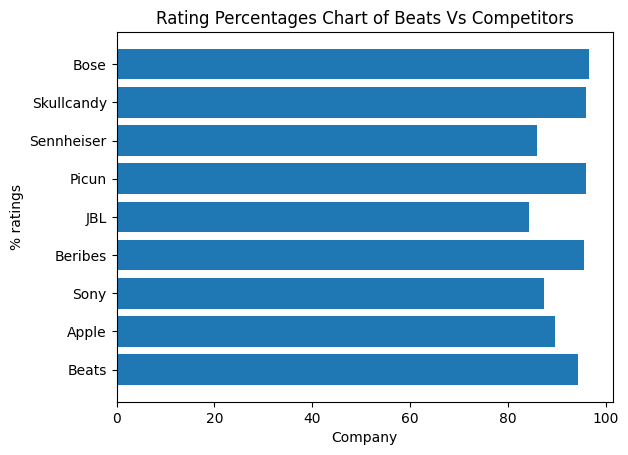

In [43]:
plt.barh(mean_ratings_companies["product_id"], mean_ratings_companies["mean_rating"])
plt.title('Rating Percentages Chart of Beats Vs Competitors')
plt.xlabel('Company')
plt.ylabel('% ratings')
plt.show()

Here is another bar plot representing the skew, or the asymmetry of our data that can indicate where most of the data points fall on our distributin, of each company's headphone product reviews. A skew closer to -1 indicates more points fall on the left side of the distribution, and in terms of ratings, that means lower ratings overall, while a skew closer to +1 indicates more points falling on the right side of the distribution and higher ratings overall for that company. Per the plot, it is evident that companies like Sennheiser, JBL, Sony, and Beats have the lowest reported skewness scores, which indicates the majority of their points fall on the higher ratings side, however as we see Beats does not have the highest skew, meaning it is not the highest rating as we saw in the other plot.

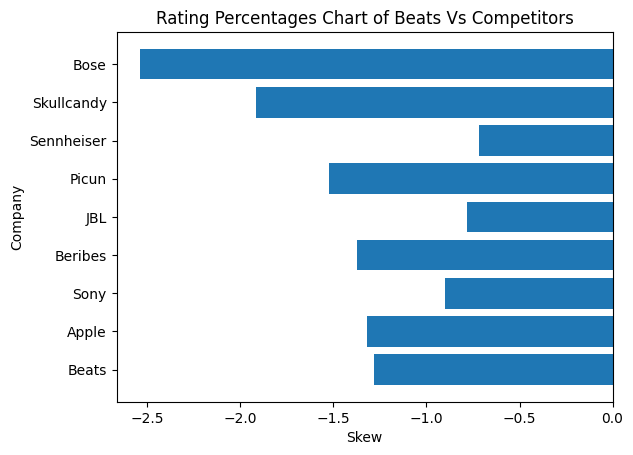

In [44]:
plt.barh(mean_ratings_companies["product_id"], skew_ratings_companies["skew"])
plt.title('Rating Percentages Chart of Beats Vs Competitors')
plt.xlabel('Skew')
plt.ylabel('Company')
plt.show()

In this facet-grid line plot, I compared the average ratings of reviews over time for the top 4 most popular rival companies: Bose, Sony, Apple, Beats. The line plot suggests consistency of ratings over the last few months, where the most recent reviews were scraped. In this sense, Beats' reviews seem to remain in high average ratings throughout the reviews, while companies like Apple skyrocket in ratings to both extremes. Beats remains the most consistent out of the four companies for good quality.

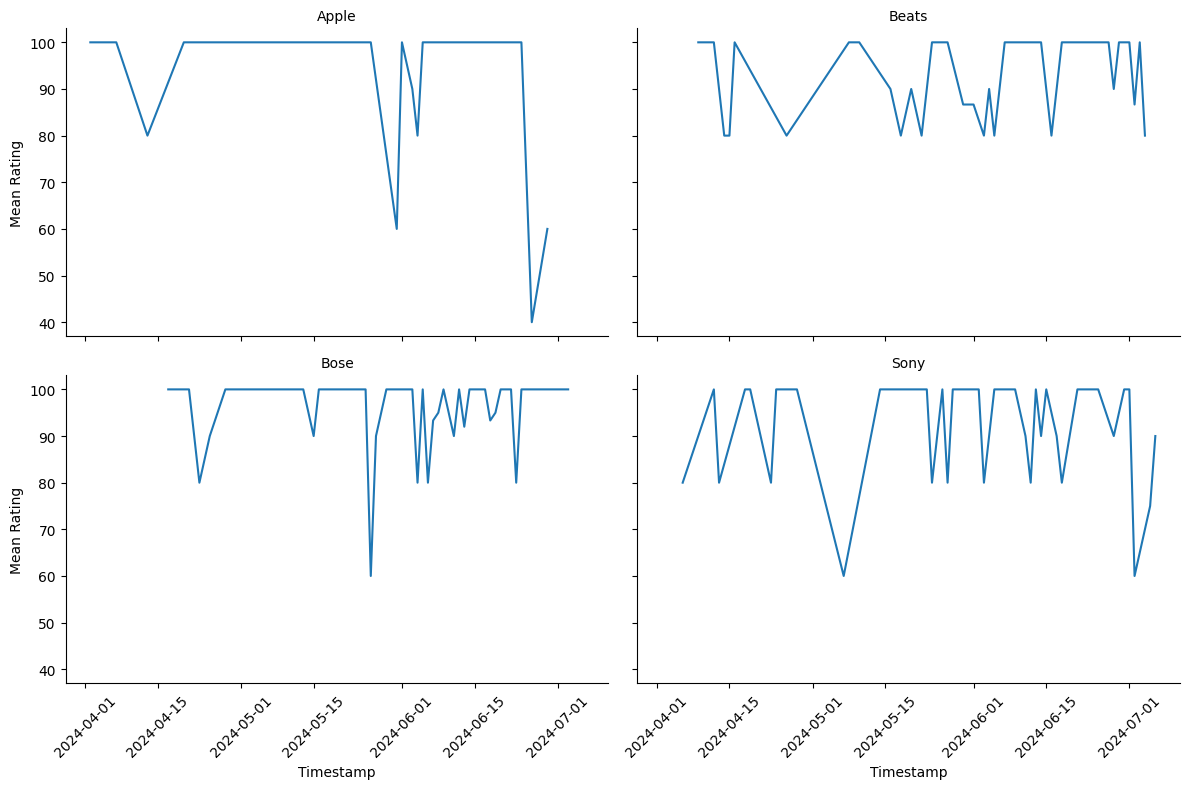

In [45]:
companies_of_interest = ['Bose', 'Sony', 'Apple', 'Beats']
filtered_data = data[data['product_id'].isin(companies_of_interest)].copy()

filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'], format='%m/%d/%Y')
comparison_date = pd.to_datetime('2024-03-31', format='%Y-%m-%d')
filtered_data = filtered_data[filtered_data['timestamp'] > comparison_date]

grouped_data = filtered_data.groupby(['product_id', 'timestamp'])['% rating'].mean().reset_index()
g = sns.FacetGrid(grouped_data, col='product_id', col_wrap=2, height=4, aspect=1.5)
g.map(sns.lineplot, 'timestamp', '% rating', errorbar=None)
g.set_titles(col_template="{col_name}")
g.set_axis_labels('Timestamp', 'Mean Rating')

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In this pie chart, I analyzed what color is most popular with Beats users, by the colors with the highest rating. While four colors appear very close in popularity, neutral tones like black and sandstone appear to be the more popular ones.

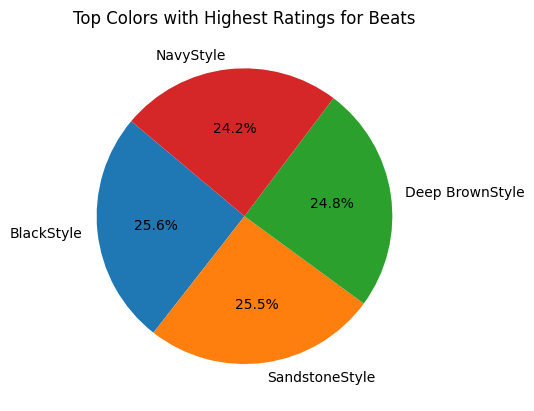

In [46]:
beats_data = data[data['product_id'] == 'Beats']
color_ratings = beats_data.groupby('color')['% rating'].mean().reset_index()
top_colors = color_ratings.nlargest(5, '% rating')

plt.pie(top_colors['% rating'], labels=top_colors['color'], autopct='%1.1f%%', startangle=140)
plt.title('Top Colors with Highest Ratings for Beats')
plt.show()

With this correlation matrix heatmap, I tried to explore the relationship between the data's two numerical variables: percentage rating of reviews and helpful count, which represents the number of people who liked/agreed with each review. Based on the off-diagonals, a correlation coefficient of -0.013 indicates there is little to no linear relationship between the two. This indicates that the helpful count is not indicative of when a product is highly rated or not, but can still be useful to explore for potential strong negative sentiment.

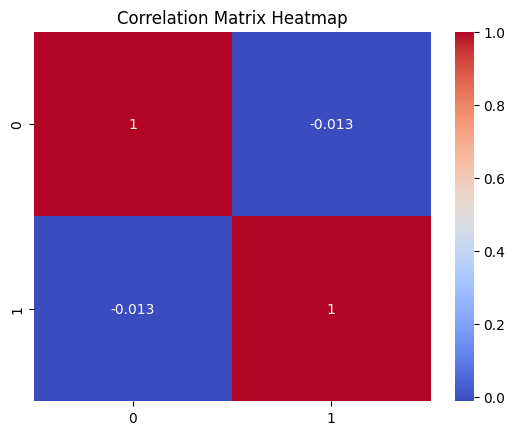

In [47]:
corr_matrix = np.corrcoef(data["% rating"], data["helpful_count"])
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

### 5.3 Descriptive Statistics
Discuss key findings from the descriptive statistics, highlighting any patterns, trends, or anomalies.

In terms of the descriptive statistics, the key findings seem to be that Beats is the most consistent with good reviews over times, and is in the top 5 of most highly rated mean of reviews, and in the top 5 of lowest skew, which places Beats in high regard in the market. This trend also seems to follow with the comparison of all the standard deviations of each company's headphones product as well. Beats seems to continuousally not be the highest in any of these statistics, but seems to be near the top for all the significant ones.

## 6. Sentiment Analysis

### 6.1 Methodology
Explain the sentiment analysis techniques used (e.g., TextBlob, NLTK) and provide code snippets.

I used Textblob to conduct my sentiment analysis. Textblob takes the content from each review and analyzes the sentiment and returns a polarity score. This polarity score determines how positive or negative a review is. If the polarity is <0 , the review is negative. If the polarity is >0, the review is positive. If the polarity is 0, the review is neutral. I conducted sentiment analysis on the "content" column of my dataframe for the top 4 competitors.

In [48]:
from textblob import TextBlob

def sentiment_analysis_summary(df, text_col):
    """
    Perform sentiment analysis on text data and return the counts of positive, negative, and neutral reviews.

    Parameters:
    df (DataFrame): The input DataFrame.
    text_col (str): The name of the column containing text data.

    Returns:
    dict: A dictionary with counts of positive, negative, and neutral reviews.
    """
    sent_dict = {'positive': 0, 'negative': 0, 'neutral': 0}

    for msg in df[text_col]:
      blob = TextBlob(msg)
      sentiment = blob.sentiment
      polarity = sentiment.polarity
      if polarity > 0:
        sent_dict["positive"] += 1
      elif polarity < 0:
        sent_dict["negative"] += 1
      else:
        sent_dict["neutral"] += 1

    return sent_dict

print("Beats:", sentiment_analysis_summary(data[data["product_id"] == "Beats"], "content"))
print("Apple:",sentiment_analysis_summary(data[data["product_id"] == "Apple"], "content"))
print("Sony:",sentiment_analysis_summary(data[data["product_id"] == "Sony"], "content"))
print("Bose:",sentiment_analysis_summary(data[data["product_id"] == "Bose"], "content"))

Beats: {'positive': 95, 'negative': 0, 'neutral': 5}
Apple: {'positive': 86, 'negative': 8, 'neutral': 6}
Sony: {'positive': 95, 'negative': 2, 'neutral': 2}
Bose: {'positive': 96, 'negative': 4, 'neutral': 0}


I similarly conducted sentiment analysis and added up the helpful count of each review to confirm if more people tend to agree/like positive or negative reviews mainly. Checking this will indicate if there is any negative traction to certain reviews and indicate if there are any immediate problem that needs solving that has a high agree count.

In [49]:
from textblob import TextBlob

def helpful_count_sentiment_analysis_summary(df, text_col, review_col):
    helpful_dict = {'positive': 0, 'negative': 0, 'neutral': 0}

    for review, helpful_count in zip(df[text_col], df[review_col]):
        blob = TextBlob(str(review))
        sentiment = blob.sentiment
        polarity = sentiment.polarity

        if polarity > 0:
            helpful_dict["positive"] += helpful_count
        elif polarity < 0:
            helpful_dict["negative"] += helpful_count
        else:
            helpful_dict["neutral"] += helpful_count

    return helpful_dict


print(helpful_count_sentiment_analysis_summary(data[data["product_id"] == "Beats"], "content", "helpful_count"))
print(helpful_count_sentiment_analysis_summary(data[data["product_id"] == "Apple"], "content", "helpful_count"))
print(helpful_count_sentiment_analysis_summary(data[data["product_id"] == "Sony"], "content", "helpful_count"))
print(helpful_count_sentiment_analysis_summary(data[data["product_id"] == "Bose"], "content", "helpful_count"))


{'positive': 1414, 'negative': 0, 'neutral': 0}
{'positive': 2329, 'negative': 3, 'neutral': 0}
{'positive': 3464, 'negative': 0, 'neutral': 0}
{'positive': 516, 'negative': 12, 'neutral': 0}


### 6.2 Results
Present the sentiment analysis results, including visualizations of sentiment distribution, and discuss the overall sentiment towards Beats by Dre products.


After collecting the data of the number of positive, negative, and neutral sentiments in the reviews of the top 4 companies, I plotted them using a bar chart. By the results, we can see that Beats has the highest value of positive values, rather than negative or neutral sentiments, and no negative sentiments detected at all.

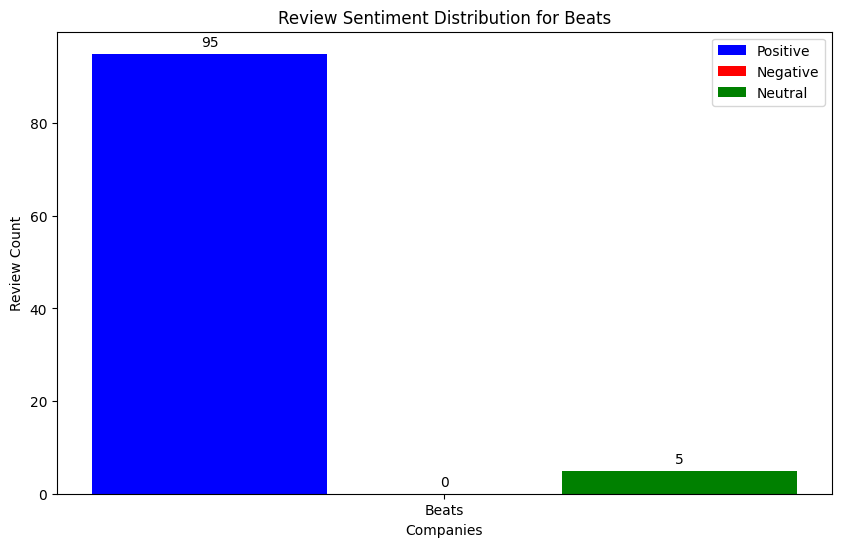

In [50]:
companies = ["Beats"]
summaries = {}

for company in companies:
    summaries[company] = sentiment_analysis_summary(data[data["product_id"] == company], "content")

positive_counts = [summaries[company]["positive"] for company in companies]
negative_counts = [summaries[company]["negative"] for company in companies]
neutral_counts = [summaries[company]["neutral"] for company in companies]

index = np.arange(len(companies))
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

bar1 = ax.bar(index - bar_width, positive_counts, bar_width, label='Positive', color='blue')
bar2 = ax.bar(index, negative_counts, bar_width, label='Negative', color='red')
bar3 = ax.bar(index + bar_width, neutral_counts, bar_width, label='Neutral', color='green')

ax.set_xlabel('Companies')
ax.set_ylabel('Review Count')
ax.set_title('Review Sentiment Distribution for Beats')
ax.set_xticks(index)
ax.set_xticklabels(companies)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.show()

## 7. AI-Generated Insights

### 7.1 Using Gemini AI
Briefly explain how Gemini AI was used to extract insights and include any relevant code snippets or explanations.

Gemini AI was used for its natural language processing abilities to generate quick summarized insights on our data reviews without having to manually scour each of the 899 remaining. To set this up, I made a Gemini AI Studio account and got an API key which I then connected with a chat session that would send messages from custom prompts I created to the API, which would then produce a response to me, using a model setup with parameters on the chatbot's response including temperature, output tokens, and conversational style.

In [51]:
import pandas as pd
import google.generativeai as genai

df = pd.read_csv('fully_cleaned_data.csv')

def analyze_reviews(reviews, api_key,prompt_message):
    genai.configure(api_key=api_key)

    model = genai.GenerativeModel(
        model_name="gemini-1.5-flash",
        generation_config={
            "temperature": 1,
            "top_p": 0.95,
            "top_k": 64,
            "max_output_tokens": 8192,
            "response_mime_type": "text/plain",
        },
    )

    chat_session = model.start_chat(history=[])

    prompt = prompt_message + "\n\n".join(reviews)
    response = chat_session.send_message(prompt)
    return response.text

### 7.2 Key Insights
Summarize the key insights generated by Gemini AI, including specific examples of prompts used and the responses received.


I generated insights from these 3 prompts.

Prompt 1: "Analyze the negative reviews of Beats headphones and summarize the key features that did not live up to user expectation:"
Response 1: While many users praise the Beats Studio Pro headphones for their sound quality, noise cancellation, and integration with Apple devices, several negative reviews highlight some shortcomings with comfort and fit, sound quality, and build quality.  Users should be aware of these potential drawbacks before making a purchase, especially if comfort, sound quality, or specific functionalities are top priorities.

Prompt 2: "Analyze the positive reviews of all the companies and summarize the features other rival companies had in their products reviews that Beats' headphones do not have but should consider adding:"
Response 2: * Based on the positive reviews of various headphone brands, here are some features that Beats headphones could consider adding to improve their offerings: improved noise cancellation, adjustable clamping force/headband, more comprehensive equalizer, dedicated mute button, improved microphone quality, option to turn off ANC, seamless multi point connection, and improved touch control responsiveness.

Prompt 3: "Analyze the positive reviews of all the companies and summarize the features Beats has in their headphones products reviews that perform exceedingly better than other competitor's product reviews:"
Response 3: Beats headphones are a great option for users who prioritize powerful bass, a stylish design, and seamless integration with Apple devices. However, if you prioritize the best noise cancellation, a balanced and detailed sound, or a wider range of features, other brands like Sony, Sennheiser, and Bose might be a better fit.

### 7.3 Interpretation
Discuss how these insights can be interpreted and their relevance to Beats by Dre.

These insights can be used to pinpoint strengths of Beats, or features of the headphones that attract and maintain users, and weaknesses, or features that the products lack or do not meet expectation. This is relevant to Beats as potentially including some of the lacking/disappointing features can help give Beats an edge over rivals and ensure customers stay pleased with their product and might potentially purchase other Beats products if the quality is right for the value.

## 8. Comparative Analysis

### 8.1 Competitor Overview
List the competitors analyzed and provide a brief overview of their market positioning.

The competitors analyzed are Bose, Apple, Sony, JBL, Sennheiser, Treblab, Picun, Beribes, and Skullcandy. Bose, Apple, and Sony appear to be the most popular of the 9 other competitors on the market, compared to the more obscure brands like Treblab, Picun and Beribes.

### 8.2 Comparison of Sentiments
Compare the sentiment analysis results of Beats by Dre with its competitors using visualizations to highlight differences and similarities.

After plotting the sentiment review distributions of Beats vs its other top 3 competitors, we can see that Beats, Sony, and Bose have the highest positive sentiment scores, however, Beats has the lowest negative sentiment score than the other companies, meaning all scraped reviews of Beats are neutral or positive.

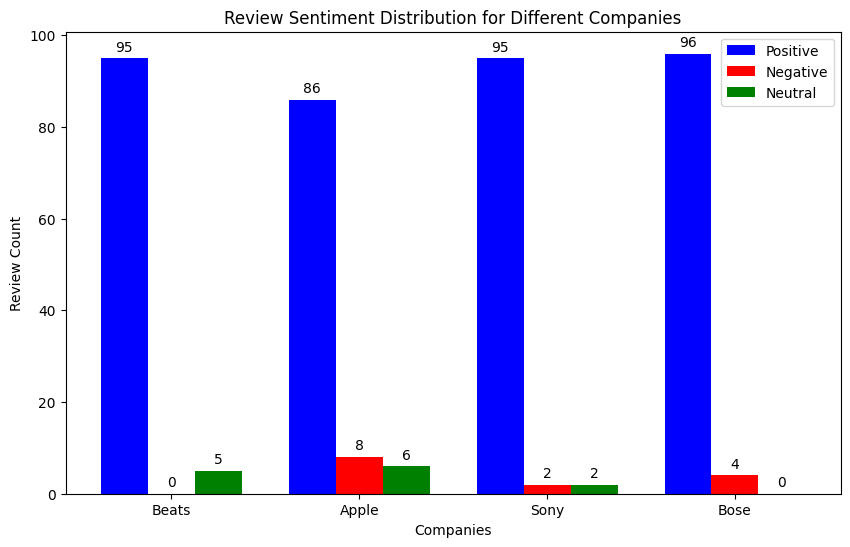

In [52]:
companies = ["Beats", "Apple", "Sony", "Bose"]
summaries = {}

for company in companies:
    summaries[company] = sentiment_analysis_summary(data[data["product_id"] == company], "content")

positive_counts = [summaries[company]["positive"] for company in companies]
negative_counts = [summaries[company]["negative"] for company in companies]
neutral_counts = [summaries[company]["neutral"] for company in companies]

index = np.arange(len(companies))
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

bar1 = ax.bar(index - bar_width, positive_counts, bar_width, label='Positive', color='blue')
bar2 = ax.bar(index, negative_counts, bar_width, label='Negative', color='red')
bar3 = ax.bar(index + bar_width, neutral_counts, bar_width, label='Neutral', color='green')

ax.set_xlabel('Companies')
ax.set_ylabel('Review Count')
ax.set_title('Review Sentiment Distribution for Different Companies')
ax.set_xticks(index)
ax.set_xticklabels(companies)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.show()

Here is the plot of the sentiment analysis for helpful count for all the competitors to confirm if more people tend to agree/like positive or negative reviews mainly. While the actual high numbers of the values, in which Sony overwhelmingly wins due to potentially higher number of reviews leading to more people looking at reviews and liking the helpful count of reviews, they do not indicate anything about the rating, as we established with our correlation matrix heatmap. Instead, this tells us that helpful counts on reviews tend to be associated with positive reviews instead mainly, signaling that people tend to agree more with positive reviews, meaning positive reviews are consistent in all the top companies.

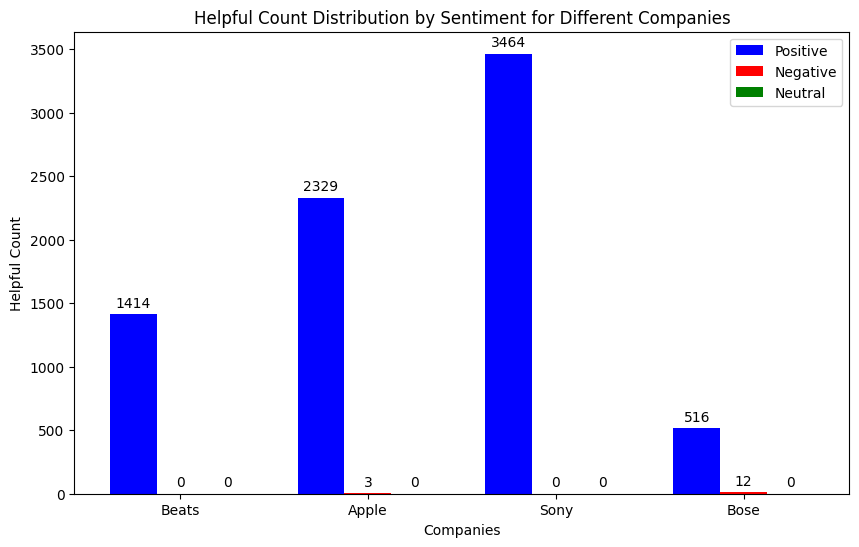

In [53]:
companies = ["Beats", "Apple", "Sony", "Bose"]
summaries = {}

for company in companies:
    summaries[company] = helpful_count_sentiment_analysis_summary(data[data["product_id"] == company], "content", "helpful_count")


sentiments = list(summaries[companies[0]].keys())
positive_counts = [summaries[company]["positive"] for company in companies]
negative_counts = [summaries[company]["negative"] for company in companies]
neutral_counts = [summaries[company]["neutral"] for company in companies]

index = np.arange(len(companies))
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

bar1 = ax.bar(index - bar_width, positive_counts, bar_width, label='Positive', color='blue')
bar2 = ax.bar(index, negative_counts, bar_width, label='Negative', color='red')
bar3 = ax.bar(index + bar_width, neutral_counts, bar_width, label='Neutral', color='green')

ax.set_xlabel('Companies')
ax.set_ylabel('Helpful Count')
ax.set_title('Helpful Count Distribution by Sentiment for Different Companies')
ax.set_xticks(index)
ax.set_xticklabels(companies)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
plt.show()


### 8.3 SWOT Analysis
Conduct a SWOT analysis (Strengths, Weaknesses, Opportunities, Threats) for Beats by Dre based on the comparative data.

Strengths for Beats headphones include powerful bass, sleek design, and easy integration with the commonly owned Apple ecosystem, and affordability.

Weaknesses for Beats headphones include noise cancellation, comfort, advanced features, and sound quality.

Opportunities for Beats headphones include adding improved noise cancellation, adjustable clamping force/headband, more comprehensive equalizer, a dedicated mute button, improved microphone quality, option to turn off ANC, seamless multi point connection, and improved touch control responsiveness.

Threats for Beats headphones include Apple, Sony, and Bose, and Sennheiser for including some of these lacking qualities in Beats.

## 9. Strategic Recommendations

### 9.1 Product Improvements
Based on the analysis, suggest specific product improvements.

To improve Beats' headphone product, I would suggest increasing the quality of the noise cancellation and mic quality, making the headphones more adjustable in band size and headphone clampability to increase comfort, adding advanced features such as an easier to navigate equalizer, mute button, option to turn off ANC, and improved touch control responsiveness.


### 9.2 Marketing Strategies
Provide recommendations for marketing strategies that could enhance consumer perception and satisfaction.

Reccomendations for marketing strategies would include potentially collabing with popular ASMR creators on YouTube, as ASMR relies heavily on audio products, and I have seen other brands such as Raycon get promotions for their audio products through ASMR youtubers. Another marketing reccomendation would be to do advertisements that show the quality of the product in a modern sense, like an advertisement where someone is listening to music using Beats headphones and feel like they're in a live concert due to the quality of the headphones, with modern popular singers featured in the concert part of the ad, such as Kendrick Lamar, especially since Dr Dre himself was seen on stage with Kendrick on tour recently. Or maybe a collab headphones cover with an artist like Charli XCX, whose album BRAT is taking over the world right now to the point where even Kamala Harris endorses it.

### 9.3 Future Research
Suggest areas for future research or additional data that could be collected to further enhance the analysis.

For future research, I would look into the color breakdown further, to see if there are any trends over time with choosing specific colors, as well as finding a way to analyze more reviews rather than just the last 100 or repeating this process every new 100 reviews to continuousally gather more data over time. I would also look into the helpful count column more to inspect if the majority of likes come from bots/an external force or if there are any patterns with helpful count and the rest of our analysis. Lastly, I might consider doing a breakdown of the gender ratio or race ratio of who buys the products more to see if Beats can widen their audience.

## 10. Conclusion
Summarize the key findings and their implications, and reflect on the overall project and its contribution to understanding consumer sentiment for Beats by Dre.

The key findings of this project include Beats being curently ranked as a high, top 5 contender in terms of rating, consistency, skewness, and more. Reviews tend to be highly positive, based on our sentiment analysis, however room for improvement includes potentially bringing Beats to a top 1 spot by adding more personalized features in terms of specific buttons and comfort adjustability so users can customize their listening experience better, as well as more enhanced sound and mic quality.

## 11. References
List all the sources, tools, and references used in the project.


References, sources, and tools I used in this project include OxyLabs for their e-commerce scraper, Amazon for the product information and URLS, and the Extern platform for example code I used as a template for my own code.